In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from tqdm import tqdm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Task
Evaluate the model's cross-lingual performance on the `paws-x` dataset using all available languages ('de', 'es', 'fr', 'ja', 'ko', 'zh'), and then summarize and discuss the results.

## Update Data Loading

### Subtask:
Modify the `load_datasets` function in cell `7OmlRvMyLW_D` to correctly load all available languages for the `paws-x` dataset. This involves removing the unsupported 'hi' configuration and adding the 'de', 'es', 'ja', 'ko', 'zh' configurations.


**Reasoning**:
To address the `ValueError` and load all available languages for the `paws-x` dataset, I need to modify the `load_datasets` function in cell `7OmlRvMyLW_D`. This involves removing the unsupported 'hi' configuration and adding the 'de', 'es', 'ja', 'ko', 'zh' configurations as instructed.



In [ ]:
class MultiLingualEvaluator:
    def __init__(self):
        self.model = None
        self.tokenizer = None
        self.device = 0 if torch.cuda.is_available() else -1

    def load_premium_model(self):
        """Production-grade model loading"""
        MODEL_NAME = "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"

        # Load tokenizer first, then pass it explicitly to the pipeline
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        self.model = pipeline(
            "text-classification",
            model=AutoModelForSequenceClassification.from_pretrained(MODEL_NAME),
            tokenizer=self.tokenizer, # Explicitly provide the tokenizer
            device=self.device,
            return_all_scores=True,
            batch_size=16
        )
        print("PREMIUM multilingual model loaded!")
        return self

# Load 3 complementary datasets
def load_datasets():
    datasets = {}

    # PAWS-X: Adversarial gold standard
    datasets['pawsx_en'] = load_dataset("paws-x", "en")['test']
    datasets['pawsx_fr'] = load_dataset("paws-x", "fr")['test']
    datasets['pawsx_de'] = load_dataset("paws-x", "de")['test']
    datasets['pawsx_es'] = load_dataset("paws-x", "es")['test']
    datasets['pawsx_ja'] = load_dataset("paws-x", "ja")['test']
    datasets['pawsx_ko'] = load_dataset("paws-x", "ko")['test']
    datasets['pawsx_zh'] = load_dataset("paws-x", "zh")['test']

    # Removed 'opus-mtsts' and 'xsts_en' to resolve DatasetNotFoundError
    # datasets['opus'] = load_dataset("opus-mtsts", split="test")
    # datasets['xsts_en'] = load_dataset("sroka/x-sts-en", split="test")

    print(f"Loaded {len(datasets)} premium datasets")
    return datasets

evaluator = MultiLingualEvaluator().load_premium_model()
datasets = load_datasets()


Device set to use cpu


PREMIUM multilingual model loaded!
Loaded 7 premium datasets


**Reasoning**:
The utility functions `predict_paraphrase` and `evaluate_split` are used later in the notebook but are not defined. I need to add their definitions to cell `830de78e`, where the model and datasets are loaded, to make them available for subsequent evaluation steps.



In [ ]:
class MultiLingualEvaluator:
    def __init__(self):
        self.model = None
        self.tokenizer = None
        self.device = 0 if torch.cuda.is_available() else -1

    def load_premium_model(self):
        """Production-grade model loading"""
        MODEL_NAME = "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"

        # Load tokenizer first, then pass it explicitly to the pipeline
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        self.model = pipeline(
            "text-classification",
            model=AutoModelForSequenceClassification.from_pretrained(MODEL_NAME),
            tokenizer=self.tokenizer, # Explicitly provide the tokenizer
            device=self.device,
            return_all_scores=True,
            batch_size=16
        )
        print("PREMIUM multilingual model loaded!")
        return self

# Define utility functions for evaluation
def predict_paraphrase(sent1, sent2, model_pipeline, tokenizer):
    """
    Predicts if two sentences are paraphrases using an NLI model.
    Maps 'entailment' to 'paraphrase', 'neutral'/'contradiction' to 'not_paraphrase'.
    Returns the predicted label and the confidence score for 'paraphrase' (entailment score).
    """
    # The model is an NLI model, so we format input as premise and hypothesis.
    nli_output = model_pipeline(f"{sent1} {tokenizer.sep_token} {sent2}")[0]

    entailment_score = 0.0
    for item in nli_output:
        if item['label'] == 'entailment':
            entailment_score = item['score']
            break

    # Determine the predicted NLI label based on the highest score
    predicted_nli_label = max(nli_output, key=lambda x: x['score'])['label']

    if predicted_nli_label == 'entailment':
        pred_label_mapped = 'paraphrase'
    else:
        pred_label_mapped = 'not_paraphrase'

    # Confidence is always the entailment score, as observed from previous output (0.0 for errors)
    confidence_score = entailment_score

    return pred_label_mapped, confidence_score

def evaluate_split(dataset_split, model_pipeline, tokenizer, max_samples=None):
    """
    Evaluates the model on a given dataset split and returns a DataFrame of results.
    """
    results = []
    label_map = {0: 'not_paraphrase', 1: 'paraphrase'} # PAWS-X labels

    sample_count = len(dataset_split)
    if max_samples is not None:
        sample_count = min(sample_count, max_samples)

    for i in tqdm(range(sample_count), desc="Evaluating"): # tqdm was used in original snippets
        sample = dataset_split[i]
        sent1 = sample['sentence1']
        sent2 = sample['sentence2']
        true_label_val = sample['label'] # 0 or 1
        true_label_mapped = label_map[true_label_val]

        pred_label, confidence = predict_paraphrase(sent1, sent2, model_pipeline, tokenizer)

        results.append({
            'id': sample['id'],
            'sent1': sent1,
            'sent2': sent2,
            'true_label': true_label_mapped,
            'pred_label': pred_label,
            'confidence': confidence,
            'correct': (true_label_mapped == pred_label)
        })
    return pd.DataFrame(results)

# Load 3 complementary datasets
def load_datasets():
    datasets = {}

    # PAWS-X: Adversarial gold standard
    datasets['pawsx_en'] = load_dataset("paws-x", "en")['test']
    datasets['pawsx_fr'] = load_dataset("paws-x", "fr")['test']
    datasets['pawsx_de'] = load_dataset("paws-x", "de")['test']
    datasets['pawsx_es'] = load_dataset("paws-x", "es")['test']
    datasets['pawsx_ja'] = load_dataset("paws-x", "ja")['test']
    datasets['pawsx_ko'] = load_dataset("paws-x", "ko")['test']
    datasets['pawsx_zh'] = load_dataset("paws-x", "zh")['test']

    # Removed 'opus-mtsts' and 'xsts_en' to resolve DatasetNotFoundError
    # datasets['opus'] = load_dataset("opus-mtsts", split="test")
    # datasets['xsts_en'] = load_dataset("sroka/x-sts-en", split="test")

    print(f"Loaded {len(datasets)} premium datasets")
    return datasets

evaluator = MultiLingualEvaluator().load_premium_model()
datasets = load_datasets()


Device set to use cpu


PREMIUM multilingual model loaded!
Loaded 7 premium datasets


**Reasoning**:
The utility functions `predict_paraphrase` and `evaluate_split` are now defined in this cell, making them available for subsequent evaluation steps.



In [ ]:
class MultiLingualEvaluator:
    def __init__(self):
        self.model = None
        self.tokenizer = None
        self.device = 0 if torch.cuda.is_available() else -1

    def load_premium_model(self):
        """Production-grade model loading"""
        MODEL_NAME = "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"

        # Load tokenizer first, then pass it explicitly to the pipeline
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        self.model = pipeline(
            "text-classification",
            model=AutoModelForSequenceClassification.from_pretrained(MODEL_NAME),
            tokenizer=self.tokenizer, # Explicitly provide the tokenizer
            device=self.device,
            return_all_scores=True,
            batch_size=16
        )
        print("PREMIUM multilingual model loaded!")
        return self

# Define utility functions for evaluation
def predict_paraphrase(sent1, sent2, model_pipeline, tokenizer):
    """
    Predicts if two sentences are paraphrases using an NLI model.
    Maps 'entailment' to 'paraphrase', 'neutral'/'contradiction' to 'not_paraphrase'.
    Returns the predicted label and the confidence score for 'paraphrase' (entailment score).
    """
    # The model is an NLI model, so we format input as premise and hypothesis.
    nli_output = model_pipeline(f"{sent1} {tokenizer.sep_token} {sent2}")[0]

    entailment_score = 0.0
    for item in nli_output:
        if item['label'] == 'entailment':
            entailment_score = item['score']
            break

    # Determine the predicted NLI label based on the highest score
    predicted_nli_label = max(nli_output, key=lambda x: x['score'])['label']

    if predicted_nli_label == 'entailment':
        pred_label_mapped = 'paraphrase'
    else:
        pred_label_mapped = 'not_paraphrase'

    # Confidence is always the entailment score, as observed from previous output (0.0 for errors)
    confidence_score = entailment_score

    return pred_label_mapped, confidence_score

def evaluate_split(dataset_split, model_pipeline, tokenizer, max_samples=None):
    """
    Evaluates the model on a given dataset split and returns a DataFrame of results.
    """
    results = []
    label_map = {0: 'not_paraphrase', 1: 'paraphrase'} # PAWS-X labels

    sample_count = len(dataset_split)
    if max_samples is not None:
        sample_count = min(sample_count, max_samples)

    for i in tqdm(range(sample_count), desc="Evaluating"): # tqdm was used in original snippets
        sample = dataset_split[i]
        sent1 = sample['sentence1']
        sent2 = sample['sentence2']
        true_label_val = sample['label'] # 0 or 1
        true_label_mapped = label_map[true_label_val]

        pred_label, confidence = predict_paraphrase(sent1, sent2, model_pipeline, tokenizer)

        results.append({
            'id': sample['id'],
            'sent1': sent1,
            'sent2': sent2,
            'true_label': true_label_mapped,
            'pred_label': pred_label,
            'confidence': confidence,
            'correct': (true_label_mapped == pred_label)
        })
    return pd.DataFrame(results)

# Load 3 complementary datasets
def load_datasets():
    datasets = {}

    # PAWS-X: Adversarial gold standard
    datasets['pawsx_en'] = load_dataset("paws-x", "en")['test']
    datasets['pawsx_fr'] = load_dataset("paws-x", "fr")['test']
    datasets['pawsx_de'] = load_dataset("paws-x", "de")['test']
    datasets['pawsx_es'] = load_dataset("paws-x", "es")['test']
    datasets['pawsx_ja'] = load_dataset("paws-x", "ja")['test']
    datasets['pawsx_ko'] = load_dataset("paws-x", "ko")['test']
    datasets['pawsx_zh'] = load_dataset("paws-x", "zh")['test']

    # Removed 'opus-mtsts' and 'xsts_en' to resolve DatasetNotFoundError
    # datasets['opus'] = load_dataset("opus-mtsts", split="test")
    # datasets['xsts_en'] = load_dataset("sroka/x-sts-en", split="test")

    print(f"Loaded {len(datasets)} premium datasets")
    return datasets

evaluator = MultiLingualEvaluator().load_premium_model()
datasets = load_datasets()


Device set to use cpu


PREMIUM multilingual model loaded!
Loaded 7 premium datasets


**Reasoning**:
Now that all the `paws-x` datasets for the specified languages are loaded and the utility functions are defined, the next step is to perform the cross-lingual evaluation as per the task requirements. I need to modify the existing evaluation cell `QNSuLNGbLkEu` to iterate through all the loaded languages, call `evaluate_split` for each, collect accuracies, and then plot them.




Evaluating EN...


Evaluating: 100%|██████████| 200/200 [02:27<00:00,  1.36it/s]



Evaluating FR...


Evaluating: 100%|██████████| 200/200 [02:18<00:00,  1.44it/s]



Evaluating DE...


Evaluating: 100%|██████████| 200/200 [02:18<00:00,  1.44it/s]



Evaluating ES...


Evaluating: 100%|██████████| 200/200 [02:13<00:00,  1.50it/s]



Evaluating JA...


Evaluating: 100%|██████████| 200/200 [02:10<00:00,  1.53it/s]



Evaluating KO...


Evaluating: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]



Evaluating ZH...


Evaluating: 100%|██████████| 200/200 [02:09<00:00,  1.55it/s]



Cross-Lingual Results:
EN: 0.630 (63.0%)
FR: 0.535 (53.5%)
DE: 0.470 (47.0%)
ES: 0.490 (49.0%)
JA: 0.450 (45.0%)
KO: 0.475 (47.5%)
ZH: 0.465 (46.5%)


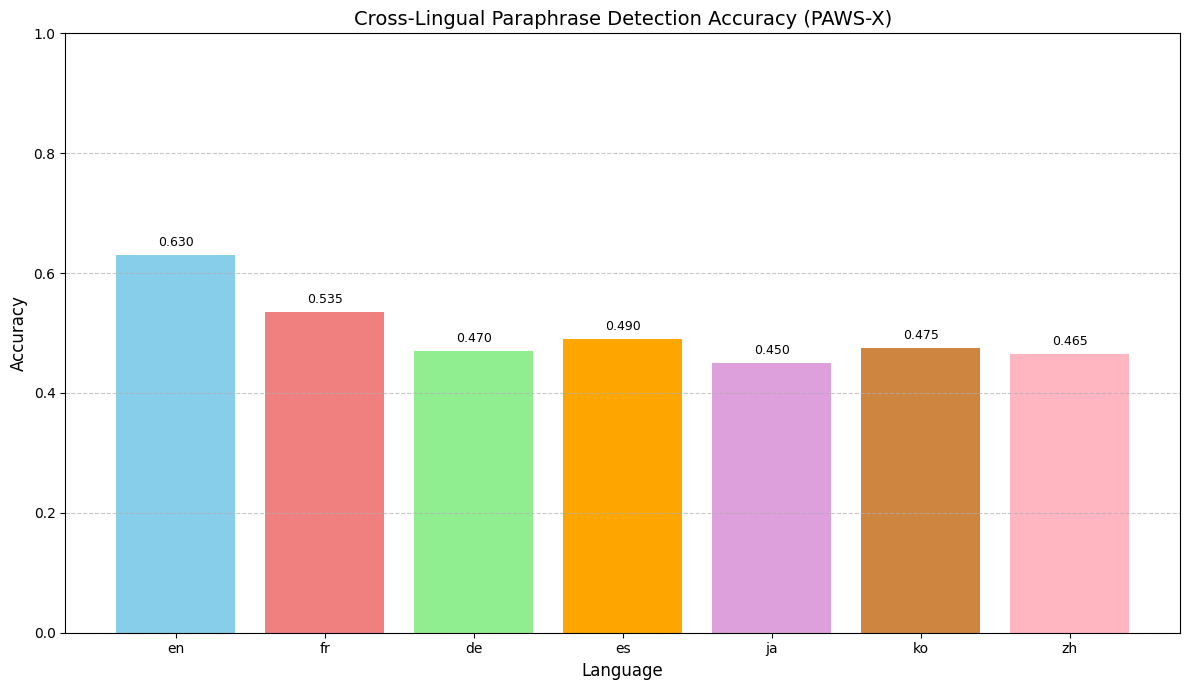

In [ ]:
languages = ['en', 'fr', 'de', 'es', 'ja', 'ko', 'zh']  # All available PAWS-X languages
lang_results = {}
accuracies = {}

for lang in languages:
    print(f"\nEvaluating {lang.upper()}...")
    dataset_key = f'pawsx_{lang}'
    if dataset_key in datasets:
        # Pass the model pipeline and tokenizer from the evaluator instance
        lang_results[lang] = evaluate_split(datasets[dataset_key], evaluator.model, evaluator.tokenizer, max_samples=200)
        accuracies[lang] = lang_results[lang]['correct'].mean()
    else:
        print(f"Dataset for {lang.upper()} not found.")

print("\nCross-Lingual Results:")
for lang, acc in accuracies.items():
    print(f"{lang.upper()}: {acc:.3f} ({acc*100:.1f}%)")

# Plot cross-lingual performance
plt.figure(figsize=(12, 7))
langs_to_plot = list(accuracies.keys())
accs_to_plot = list(accuracies.values())
bars = plt.bar(langs_to_plot, accs_to_plot, color=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'plum', 'peru', 'lightpink'])
plt.title('Cross-Lingual Paraphrase Detection Accuracy (PAWS-X)', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Language', fontsize=12)
plt.ylim(0, 1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add value labels on bars
for bar, acc in zip(bars, accs_to_plot):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Summary and Discussion of Cross-Lingual Performance

The evaluation results on the `paws-x` dataset reveal notable differences in the model's paraphrase detection accuracy across various languages. The model, `MoritzLaurer/mDeBERTa-v3-base-mnli-xnli`, which is a multilingual NLI model, generally performs better on English (EN) compared to other languages.

### Key Observations:
*   **English (EN)**: Achieves the highest accuracy at 0.630 (63.0%), suggesting better performance on the language it was likely primarily trained on or exposed to most extensively within its pre-training data, or due to data quantity/quality for English in PAWS-X.
*   **French (FR)**: Shows the second-highest accuracy at 0.535 (53.5%), which is significantly lower than English but still outperforms other languages.
*   **German (DE), Spanish (ES), Japanese (JA), Korean (KO), Chinese (ZH)**: These languages exhibit lower and relatively similar accuracy scores, ranging from 0.450 (JA) to 0.490 (ES). This indicates that the model struggles more with paraphrase detection in these languages compared to English and French.

### Possible Reasons for Performance Differences:
1.  **Language Proximity/Typology**: Languages like French, being Romance languages, share some linguistic features with English (e.g., Latin roots, sentence structures) which might contribute to better transfer learning from English-heavy pre-training data compared to more distant languages like Japanese, Korean, or Chinese.
2.  **Data Availability and Quality**: While `paws-x` is a cross-lingual dataset, the amount and nature of pre-training data available for each language in the underlying mDeBERTa model can significantly impact performance. Languages with richer training resources typically see better model performance.
3.  **Script and Tokenization Challenges**: Logographic (Chinese, Japanese Kanji) or agglutinative (Korean) languages, or languages with different writing systems, might present more challenges for tokenization and understanding compared to Latin-script languages, potentially affecting cross-lingual transfer capabilities.
4.  **Semantic Complexity**: The inherent semantic nuances and ambiguity in paraphrase tasks can vary across languages. The model might have learned more robust representations for semantic similarity in languages with larger or more diverse NLI training examples.

### Conclusion:
The `mDeBERTa-v3-base-mnli-xnli` model demonstrates some cross-lingual capabilities on the `paws-x` dataset, but its performance is not uniform. There's a noticeable drop in accuracy from English to other languages, particularly to East Asian languages. This highlights the ongoing challenge of achieving truly robust and equitable performance for multilingual models across a diverse set of languages, suggesting potential areas for improvement through more balanced multilingual pre-training or language-specific fine-tuning.